# Gluon interface example for `fred_md`

This notebook contains an example of training the TACTiS model on the `fred_md` dataset, using the same hyperparameters as in the paper, but with a reduced training time.

In [1]:
# Configuration
import os
import sys
REPO_NAME = "tactis"
def get_repo_basepath():
    cd = os.path.abspath(os.curdir)
    return cd[:cd.index(REPO_NAME) + len(REPO_NAME)]
REPO_BASE_PATH = get_repo_basepath()
sys.path.append(REPO_BASE_PATH)

In [2]:
from pts import Trainer
import torch
from tactis.gluon.estimator import TACTiSEstimator
from tactis.gluon.dataset import generate_hp_search_datasets, generate_backtesting_datasets
from tactis.gluon.metrics import compute_validation_metrics
from tactis.gluon.plots import plot_four_forecasts
from gluonts.evaluation.backtest import make_evaluation_predictions

/home/coder/anaconda3/envs/new_tactis/lib/python3.9/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


## Loading the dataset

This loads the dataset as it was used during the hyperparameter search experiments.

In [3]:
history_factor = 1

metadata, train_data, valid_data = generate_hp_search_datasets("fred_md", history_factor)

/home/coder/anaconda3/envs/new_tactis/lib/python3.9/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/home/coder/anaconda3/envs/new_tactis/lib/python3.9/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(timestamp.freq, Tick):
/home/coder/anaconda3/envs/new_tactis/lib/python3.9/site-packages/gluonts/dataset/common.py:338: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return timestamp.freq.rollforward(timestamp)
/home/coder/anaconda3/envs/new_tactis/lib/python3.9/site-packages/gluonts/dataset/multivariate_grouper.py:106: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  timestamp + (len(data[FieldName.TARGET]) - 1) * timestamp.freq,
/home/coder/anaconda3/envs/new_ta

## Creating the GluonTS Estimator object

The following hyperparameters (together with the history factor of 1) are those used in our benchmark for `fred_md`, although with a reduced training time since we took a limit of 3 days for our benchmark.

In [4]:
estimator = TACTiSEstimator(
    model_parameters = {
        "series_embedding_dim": 5,
        "input_encoder_layers": 2,
        "input_encoding_normalization": True,
        "data_normalization": "standardization",
        "loss_normalization": "series",
        "bagging_size": 20,
        "positional_encoding":{
            "dropout": 0.0,
        },
        "temporal_encoder":{
            "attention_layers": 2,
            "attention_heads": 1,
            "attention_dim": 16,
            "attention_feedforward_dim": 16,
            "dropout": 0.0,
        },
        "copula_decoder":{
            "min_u": 0.05,
            "max_u": 0.95,
            "attentional_copula": {
                "attention_heads": 3,
                "attention_layers": 1,
                "attention_dim": 8,
                "mlp_layers": 2,
                "mlp_dim": 48,
                "resolution": 20,
            },
            "dsf_marginal": {
                "mlp_layers": 2,
                "mlp_dim": 48,
                "flow_layers": 2,
                "flow_hid_dim": 8,
            },
        },
    },
    num_series = train_data.list_data[0]["target"].shape[0],
    history_length = history_factor * metadata.prediction_length,
    prediction_length = metadata.prediction_length,
    freq = metadata.freq,
    trainer = Trainer(
        epochs = 100,
        batch_size = 256,
        num_batches_per_epoch = 512,
        learning_rate = 1e-3,
        weight_decay = 1e-4,
        maximum_learning_rate = 1e-3,
        clip_gradient = 1e3,
        device = torch.device("cuda"),
    ),
    cdf_normalization = False,
    num_parallel_samples = 100,
)

## The training

In [5]:
predictor = estimator.train(train_data, valid_data)

  0%|          | 0/511 [00:00<?, ?it/s]

/home/coder/anaconda3/envs/new_tactis/lib/python3.9/site-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)


  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

## Metrics

Measuring the metrics on the validation dataset. Note that we use `split=True` due to the validation dataset not already being split into multiple timestamps.

We reduce the batch size since we generate many samples in parallel (see the `num_parallel_samples` parameter of the Estimator object), without using bagging. The extra memory usage is somewhat compensated by not having to keep gradient information, but not completely.

In [6]:
predictor.batch_size = 16
metrics = compute_validation_metrics(
    predictor=predictor,
    dataset=valid_data,
    window_length=estimator.history_length + estimator.prediction_length,
    num_samples=100,
    split=True,
)

In [7]:
metrics

{'CRPS': 0.0733482661397193,
 'ND': 0.09008451581267364,
 'NRMSE': 0.8771505813220523,
 'MSE': 719814817.3873976,
 'CRPS-Sum': 0.042190383207425776,
 'ND-Sum': 0.0533835682014799,
 'NRMSE-Sum': 0.07451291899017101,
 'MSE-Sum': 58220498199.111115,
 'Energy': 633800.8290488762,
 'num_nan': 0,
 'num_inf': 0}

## Plotting the forecasts

Plot the forecast for the last timestamp of the validation dataset.

In [8]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=valid_data, predictor=predictor, num_samples=100
)
forecasts = list(forecast_it)
targets = list(ts_it)

/home/coder/anaconda3/envs/new_tactis/lib/python3.9/site-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)


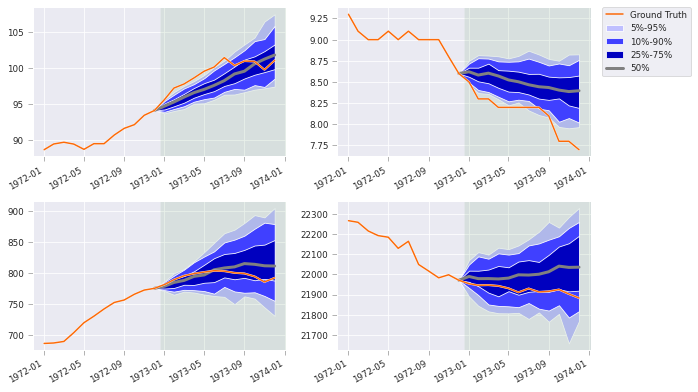

In [9]:
plot_four_forecasts(
    forecasts=forecasts,
    targets=targets,
    selection=[(0, 10), (0, 20), (0, 30), (0, 40)],
    tick_freq="4 months end",
    history_length=estimator.history_length,
)

## Loading and training with the backtesting dataset

Similar to how the dataset was loaded for the hyperparameter search, but we need to select a backtesting id.

In [10]:
backtest_id = 3
metadata, backtest_train_data, backtest_test_data = generate_backtesting_datasets("fred_md", backtest_id, history_factor)

/home/coder/anaconda3/envs/new_tactis/lib/python3.9/site-packages/gluonts/dataset/multivariate_grouper.py:106: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  timestamp + (len(data[FieldName.TARGET]) - 1) * timestamp.freq,
/home/coder/anaconda3/envs/new_tactis/lib/python3.9/site-packages/gluonts/dataset/multivariate_grouper.py:108: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self.frequency = timestamp.freq
/home/coder/anaconda3/envs/new_tactis/lib/python3.9/site-packages/gluonts/dataset/multivariate_grouper.py:217: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  freq=data[FieldName.START].freq,
/home/coder/anaconda3/envs/new_tactis/lib/python3.9/site-packages/gluonts/dataset/multivariate_grouper.py:166: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  freq=data[FieldName.START].freq,
/home/coder/anaconda3/envs/new_tactis/lib/pyth

In [11]:
predictor = estimator.train(backtest_train_data)

  0%|          | 0/511 [00:00<?, ?it/s]

/home/coder/anaconda3/envs/new_tactis/lib/python3.9/site-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)


  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

## Metrics for the testing dataset

Unlike the validation dataset, the testing dataset is already split, so no need to ask the metrics method to split it.

In [12]:
predictor.batch_size = 16
metrics = compute_validation_metrics(
    predictor=predictor,
    dataset=backtest_test_data,
    window_length=estimator.history_length + estimator.prediction_length,
    num_samples=100,
    split=False,
)

/home/coder/anaconda3/envs/new_tactis/lib/python3.9/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/home/coder/anaconda3/envs/new_tactis/lib/python3.9/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(timestamp.freq, Tick):
/home/coder/anaconda3/envs/new_tactis/lib/python3.9/site-packages/gluonts/dataset/common.py:338: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return timestamp.freq.rollforward(timestamp)


In [13]:
metrics

{'CRPS': 0.05520261579825125,
 'ND': 0.0668031130210693,
 'NRMSE': 0.6859015298153799,
 'MSE': 1142197584.7687945,
 'CRPS-Sum': 0.05436085149056257,
 'ND-Sum': 0.06411745126710952,
 'NRMSE-Sum': 0.07024968256274235,
 'MSE-Sum': 137174701397.33333,
 'Energy': 951816.9617929293,
 'num_nan': 0,
 'num_inf': 0}